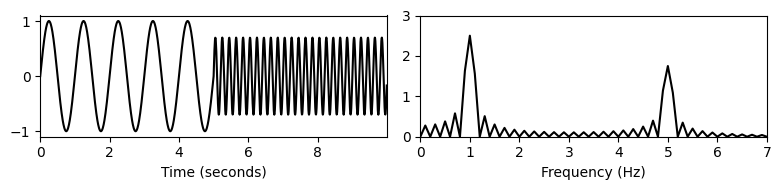

In [1]:
import os
import numpy as np
import matplotlib
from  matplotlib import pyplot as plt
import librosa
from ipywidgets import interact, fixed, FloatSlider
import IPython.display as ipd
%matplotlib inline

Fs = 128
duration = 10
omega1 = 1
omega2 = 5
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(t, x, c='k')
plt.xlim([min(t), max(t)])
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
X = np.abs(np.fft.fft(x)) / Fs
freq = np.fft.fftfreq(N, d=1/Fs)
X = X[:N//2]
freq = freq[:N//2]
plt.plot(freq, X, c='k')
plt.xlim([0, 7])
plt.ylim([0, 3])
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

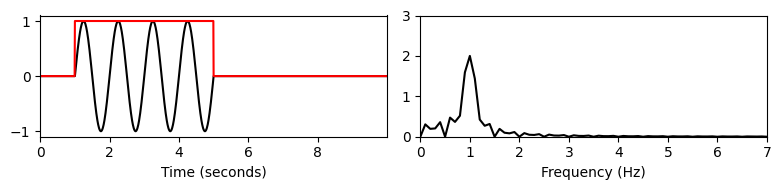

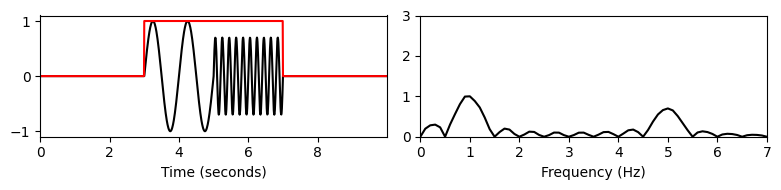

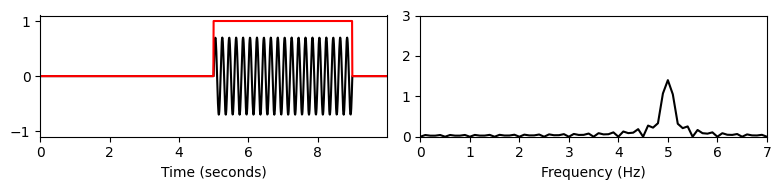

Interactive interface for experimenting with different window shifts:


interactive(children=(FloatSlider(value=1.7, continuous_update=False, description='Position', max=6.0), Output…

In [2]:
def windowed_ft(t, x, Fs, w_pos_sec, w_len):

    N = len(x)
    w_pos = int(Fs * w_pos_sec)
    w_padded = np.zeros(N)
    w_padded[w_pos:w_pos + w_len] = 1
    x = x * w_padded
    plt.figure(figsize=(8, 2))

    plt.subplot(1, 2, 1)
    plt.plot(t, x, c='k')
    plt.plot(t, w_padded, c='r')
    plt.xlim([min(t), max(t)])
    plt.ylim([-1.1, 1.1])
    plt.xlabel('Time (seconds)')

    plt.subplot(1, 2, 2)
    X = np.abs(np.fft.fft(x)) / Fs
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    plt.plot(freq, X, c='k')
    plt.xlim([0, 7])
    plt.ylim([0, 3])
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

w_len = 4 * Fs
windowed_ft(t, x, Fs, w_pos_sec=1, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=3, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=5, w_len=w_len)

print('Interactive interface for experimenting with different window shifts:')
interact(windowed_ft,
         w_pos_sec=FloatSlider(min=0, max=duration-(w_len/Fs), step=0.1,
                continuous_update=False, value=1.7, description='Position'),
                t=fixed(t), x=fixed(x), Fs=fixed(Fs), w_len=fixed(w_len));

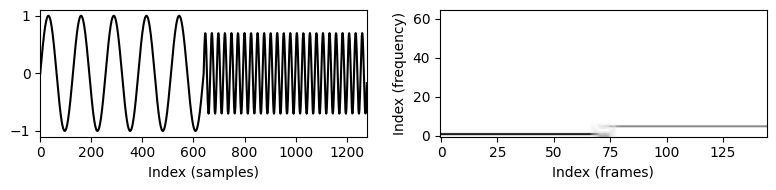

In [4]:
def stft_basic(x, w, H=8, only_positive_frequencies=False):
   L = len(x)
   M = np.floor((L - N) / H).astype(int) + 1
   X = np.zeros((N, M), dtype='complex')
   for m in range(M):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win

   if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
   return X

H = 8
N = 128
w = np.ones(N)
X = stft_basic(x, w, H, only_positive_frequencies=True)
Y = np.abs(X) ** 2

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(t)), x, c='k')
plt.xlim([0, len(t)])
plt.xlabel('Index (samples)')
plt.subplot(1, 2, 2)
plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r')
plt.xlabel('Index (frames)')
plt.ylabel('Index (frequency)')
plt.tight_layout()

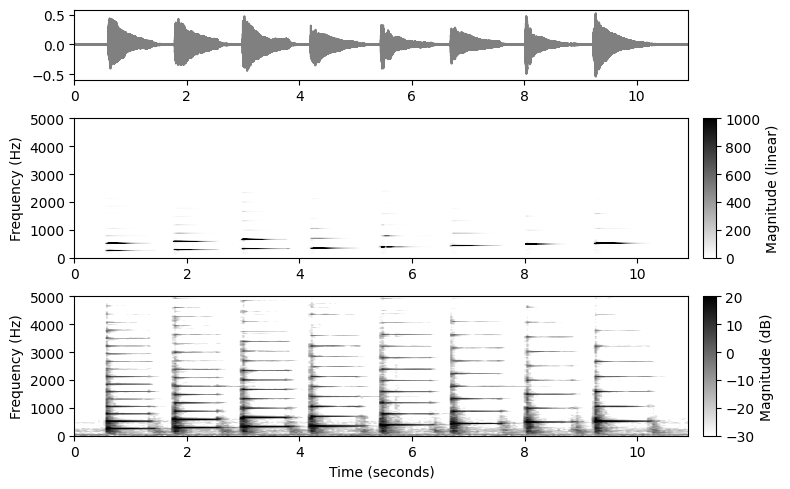

In [5]:
x, Fs = librosa.load('/content/FMP_C2_F10.wav')

H = 1024
N = 2048
w = np.hanning(N)
X = stft_basic(x, w, H)
Y = np.abs(X) ** 2
eps = np.finfo(float).eps
Y_db = 10 * np.log10(Y + eps)

T_coef = np.arange(X.shape[1]) * H / Fs
F_coef = np.arange(X.shape[0]) * Fs / N


fig = plt.figure(figsize=(8, 5))

gs = matplotlib.gridspec.GridSpec(3, 2, height_ratios=[1, 2, 2], width_ratios=[100, 2])
ax1, ax2, ax3, ax4, ax5, ax6 = [plt.subplot(gs[i]) for i in range(6)]

t = np.arange(len(x)) / Fs
ax1.plot(t, x, c='gray')
ax1.set_xlim([min(t), max(t)])

ax2.set_visible(False)

left = min(T_coef)
right = max(T_coef) + N / Fs
lower = min(F_coef)
upper = max(F_coef)

im1 = ax3.imshow(Y, origin='lower', aspect='auto', cmap='gray_r',
                 extent=[left, right, lower, upper])
im1.set_clim([0, 1000])
ax3.set_ylim([0, 5000])
ax3.set_ylabel('Frequency (Hz)')
cbar = fig.colorbar(im1, cax=ax4)
ax4.set_ylabel('Magnitude (linear)', rotation=90)

im2 = ax5.imshow(Y_db, origin='lower', aspect='auto', cmap='gray_r',
                 extent=[left, right, lower, upper])
im2.set_clim([-30, 20])
ax5.set_ylim([0, 5000])
ax5.set_xlabel('Time (seconds)')
ax5.set_ylabel('Frequency (Hz)')
cbar = fig.colorbar(im2, cax=ax6)
ax6.set_ylabel('Magnitude (dB)', rotation=90)

plt.tight_layout()